In [1]:
%matplotlib inline

In [2]:
import glob
from Bio import Phylo, SeqIO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import defaultdict

# from scipy import stats

In [3]:
monophyly_df = pd.read_csv('../Data/OMA_group_data/eukaryotes/tree_monophyly.csv', index_col='Group_id')
# monophyly_df = pd.read_csv('../Data/Tria_et_al_data/eukaryotes/tree_monophyly.csv', index_col='Group_id')
print(monophyly_df.shape)
monophyly_df.head(n=10)

(400, 9)


,monophyletic_clade,other_clade,root_bl,monophyletic_total_bl,other_total_bl,total_tree_bl,total_n,monophyletic_n,other_n
Group_id,,,,,,,,,
OMAGroup_789494,IntNode_3,IntNode_88,1.49293,69.00150,56.46590,126.96033,194.0,89.0,105.0
OMAGroup_555430,IntNode_46,IntNode_73,1.00116,30.16103,38.54124,69.70343,222.0,94.0,128.0
OMAGroup_828657,IntNode_43,IntNode_49,0.97504,16.43967,28.31956,45.73427,172.0,50.0,122.0
OMAGroup_804387,IntNode_48,IntNode_76,0.37875,20.59071,17.27605,38.24551,233.0,97.0,136.0
OMAGroup_809161,IntNode_3,IntNode_95,3.04869,32.59700,28.92590,64.57159,213.0,96.0,117.0
OMAGroup_839524,IntNode_42,IntNode_67,1.74309,17.51860,17.52166,36.78335,191.0,68.0,123.0
OMAGroup_840929,IntNode_65,IntNode_88,0.32456,17.32818,19.81383,37.46657,210.0,88.0,122.0
OMAGroup_677247,IntNode_4,IntNode_64,1.59976,50.28686,35.68908,87.57570,178.0,89.0,89.0
OMAGroup_692878,IntNode_67,IntNode_92,0.44295,12.02369,15.02454,27.49118,229.0,93.0,136.0


# Quantifying accuracy

In [79]:
orig_dir = '../Data/OMA_group_data/eukaryotes/processed_OMA_trees/*RootedNoZero.MPAJH'

frac_to_analyze = 'frac0.9'
prune_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*.{}.*RootedNoZero.MPAJH'.format(frac_to_analyze)
    
methods = ['.MPAJH']

# methods = ['.MPAJH', '.MinVarAJH']
methods = ['.MPAJH',\
           '.MinVarAJH', '.MinVarGSCAJH', '.MinVarGSCnAJH', '.MinVarHHAJH',\
          '.MADAJH', '.MADweightAJH', '.MADweightNormedAJH']
results_dict = defaultdict(list)

for prune_loc in glob.glob(prune_dir)[:]:
    group = prune_loc.split('/')[-1].split('.')[0]
    if type(monophyly_df.loc[group]['monophyletic_clade']) != str:
        continue
    correct_clade_a = monophyly_df.loc[group]['monophyletic_clade']
    correct_clade_b = monophyly_df.loc[group]['other_clade']
    correct_clades = [correct_clade_a, correct_clade_b]
    correct_len = monophyly_df.loc[group]['root_bl']
    for method in methods:
        prune_tree = Phylo.read(prune_loc.replace('.MPAJH', method), 'newick', rooted=True)
        correct = []
        incorrect = []
        for clade in prune_tree.root.clades:
            if clade.name in correct_clades:
                correct.append(clade)
            else:
                incorrect.append(clade)
        ###Totally wrong
        if len(correct) == 0:
            results_dict[method].append(0) 
            
        ###Nice and easy, correct
        elif len(correct) == 2:
            results_dict[method].append(1)
            
        ###These could be correct or incorrect and need more work
        elif len(correct) == 1:
            #Make sure the orientation is correct
            if correct[0].name == monophyly_df.loc[group]['monophyletic_clade']:
                if len(correct[0].get_terminals()) != int(monophyly_df.loc[group]['monophyletic_n']):
                    results_dict[method].append(0)
                else:
                    if correct[0].branch_length < monophyly_df.loc[group]['root_bl']:
                        results_dict[method].append(1)
                    else:
                        results_dict[method].append(0)
            elif correct[0].name == monophyly_df.loc[group]['other_clade']:
                if len(correct[0].get_terminals()) != int(monophyly_df.loc[group]['other_n']):
                    results_dict[method].append(0)
                else:
                    if correct[0].branch_length < monophyly_df.loc[group]['root_bl']:
                        results_dict[method].append(1)
                    else:
                        results_dict[method].append(0)
        elif len(correct) > 2:
            print('Total catastrophe here, investigate')


        
        
        

In [80]:
for method in methods:
    print(method, np.sum(results_dict[method]))

.MPAJH 221
.MinVarAJH 243
.MinVarGSCAJH 255
.MinVarGSCnAJH 201
.MinVarHHAJH 256
.MADAJH 230
.MADweightAJH 251
.MADweightNormedAJH 248


In [96]:
print(np.nanmedian(monophyly_df['monophyletic_total_bl']/monophyly_df['monophyletic_n']),\
np.nanmedian(monophyly_df['other_total_bl']/monophyly_df['other_n']))

print(np.nanmedian(monophyly_df['monophyletic_n']),\
np.nanmedian(monophyly_df['other_n']))


print(np.nanmedian(monophyly_df['monophyletic_total_bl']),\
np.nanmedian(monophyly_df['other_total_bl']))

0.37734585493709494 0.2428527568627451
85.0 114.5
30.62062 26.923200000000005


In [92]:
from scipy import stats
stats.wilcoxon(monophyly_df['monophyletic_n']/monophyly_df['monophyletic_total_bl'],\
               monophyly_df['other_n']/monophyly_df['other_total_bl'])

/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/scipy/stats/morestats.py:2391: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/scipy/stats/morestats.py:2392: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


WilcoxonResult(statistic=3904.0, pvalue=3.650684580834712e-55)

# I f'd this up but this should be a calculation of distance from balanced to un-balanced

In [12]:
orig_dir = '../Data/OMA_group_data/eukaryotes/processed_OMA_trees/*RootedNoZero.MPAJH'
prune_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/'
methods = ['.MPAJH']

methods = ['.MPAJH', '.MinVarAJH']
# methods = ['.MPAJH',\
#            '.MinVarAJH', '.MinVarGSCAJH', '.MinVarGSCnAJH', '.MinVarHHAJH',\
#           '.MADAJH', '.MADweightAJH', '.MADweightNormedAJH']
results_dict = defaultdict(list)

for tree_loc in glob.glob(orig_dir)[0:10]:
    print(tree_loc)
    group = tree_loc.split('/')[-1].split('.')[0]
    prune_loc = prune_dir+'{}.{}.treefile.RootedNoZero.MPAJH'.format(group, 'frac0.5')
    if type(monophyly_df.loc[group]['monophyletic_clade']) != str:
        continue
    for method in methods:
        my_tree = Phylo.read(tree_loc.replace('.MPAJH', method), 'newick', rooted=True)
        prune_tree = Phylo.read(prune_loc.replace('.MPAJH', method), 'newick', rooted=True)
        my_tree_depths = my_tree.depths()
        keys, vals = zip(*my_tree_depths.items())
        new_keys = [i.name for i in keys]
        my_tree_depths = dict(zip(new_keys, vals))
        prune_tree_depths = prune_tree.depths()
        keys, vals = zip(*prune_tree_depths.items())
        new_keys = [i.name for i in keys]
        prune_tree_depths = dict(zip(new_keys, vals))
        dists = []
        for terminal in my_tree.get_terminals():
            if terminal.name in new_keys:
                dists.append(my_tree_depths[terminal.name] - prune_tree_depths[terminal.name])
        results_dict[method].append(np.max(np.abs(np.array(dists)))/prune_tree.total_branch_length())

../Data/OMA_group_data/eukaryotes/processed_OMA_trees/OMAGroup_789494.treefile.RootedNoZero.MPAJH
../Data/OMA_group_data/eukaryotes/processed_OMA_trees/OMAGroup_555430.treefile.RootedNoZero.MPAJH
../Data/OMA_group_data/eukaryotes/processed_OMA_trees/OMAGroup_828657.treefile.RootedNoZero.MPAJH
../Data/OMA_group_data/eukaryotes/processed_OMA_trees/OMAGroup_804387.treefile.RootedNoZero.MPAJH
../Data/OMA_group_data/eukaryotes/processed_OMA_trees/OMAGroup_809161.treefile.RootedNoZero.MPAJH
../Data/OMA_group_data/eukaryotes/processed_OMA_trees/OMAGroup_839524.treefile.RootedNoZero.MPAJH
../Data/OMA_group_data/eukaryotes/processed_OMA_trees/OMAGroup_840929.treefile.RootedNoZero.MPAJH
../Data/OMA_group_data/eukaryotes/processed_OMA_trees/OMAGroup_677247.treefile.RootedNoZero.MPAJH
../Data/OMA_group_data/eukaryotes/processed_OMA_trees/OMAGroup_692878.treefile.RootedNoZero.MPAJH
../Data/OMA_group_data/eukaryotes/processed_OMA_trees/OMAGroup_696620.treefile.RootedNoZero.MPAJH


In [11]:
#0.05
for method in methods:
    print(method, '\t', np.mean(results_dict[method]))

.MPAJH 	 0.0011170873781810083
.MinVarAJH 	 0.0001848194861628677
.MinVarGSCAJH 	 0.003171965064237437
.MinVarGSCnAJH 	 0.0018180184645839282
.MinVarHHAJH 	 0.00034536483313156745
.MADAJH 	 0.00017073605193285924
.MADweightAJH 	 0.00023308774392879672
.MADweightNormedAJH 	 0.00021901433790349258


In [83]:
#0.95
# for method in methods:
#     print(method, '\t', np.mean(results_dict[method]))

.MPAJH 	 0.00798321908574
.MinVarAJH 	 0.00952432724694
.MinVarGSCAJH 	 0.00904352593287
.MinVarGSCnAJH 	 0.0219535140512
.MinVarHHAJH 	 0.00745206131049
.MADAJH 	 0.0123741288923
.MADweightAJH 	 0.00825105637581
.MADweightNormedAJH 	 0.00966480962016


(191,)

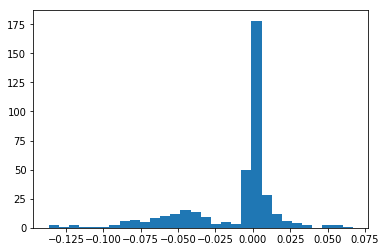

In [102]:
a = '.MinVarAJH'
b = '.MinVarGSCnAJH'
fig, ax = plt.subplots()
ax.hist(np.array(results_dict[a])-np.array(results_dict[b]), 30)
np.where(np.array(results_dict[a])-np.array(results_dict[b]) > 0.)[0].shape

In [50]:
for terminal in my_tree.get_terminals():
    if terminal.name in new_keys:
        print(my_tree_depths[terminal.name] - prune_tree_depths[terminal.name])

0.49851
0.49851
0.49851
0.49851
0.49851
0.49851
0.49851
0.49851
0.49851
0.49851
0.49851
0.49851
0.49851
0.49851000000000023
0.49851000000000023
0.49851000000000023
0.49851
0.49851
0.49851
0.49851
0.49851
0.4985099999999998
0.4985099999999999
0.4985099999999998
0.4985099999999998
0.49851
0.49851
0.4985099999999998
0.4985099999999998
0.4985099999999998
0.4985099999999998
0.4985099999999998
0.4985099999999998
0.4985099999999998
0.4985099999999998
0.4985099999999998
0.49851
0.49851
0.49851
0.49851
0.49851000000000023
0.49851
0.49851
0.4985099999999998
0.4985099999999998
0.49851
0.49851
0.4985099999999998
0.49851
0.49851
0.49851
0.49851
-0.49851000000000023
-0.49851
-0.49851


In [16]:
# trees_dir = '../Data/OMA_group_data/eukaryotes/processed_OMA_trees/*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/processed_OMA_trees/*Terms.Rooted.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.05*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.5*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/OMA_group_data/eukaryotes/pruned_OMA_trees/*frac0.95*treefile.RootedNoZero.MPAJH'
# trees_dir = '../Data/Tria_et_al_data/eukaryotes/processed_trees/*treefile.RootedNoZero.MPAJH'
trees_dir = '../Data/Tria_et_al_data/eukaryotes/pruned_trees/*frac0.9*treefile.RootedNoZero.MPAJH'


# methods = ['.MPAJH','.MinVarAJH', '.MADAJH']
methods = ['.MPAJH',\
           '.MinVarAJH', '.MinVarGSCAJH', '.MinVarGSCnAJH', '.MinVarHHAJH',\
          '.MADAJH', '.MADweightAJH', '.MADweightNormedAJH']
# methods = ['.MPAJH',\
#            '.MinVarAJH', '.MinVarGSCAJH', '.MinVarGSCnAJH', '.MinVarHHAJH']

for method in methods:
    monophyly_df['{}_success'.format(method)] = np.nan

trees_tested = []

for tree_loc in glob.glob(trees_dir)[:]:
#     print(tree_loc)
    group = tree_loc.split('/')[-1].split('.')[0]
    if type(monophyly_df.loc[group]['monophyletic_clade']) != str:
        continue
    for method in methods:
        my_tree = Phylo.read(tree_loc.replace('.MPAJH', method), 'newick', rooted=True)
        internals = [i.name for i in my_tree.get_nonterminals()]
        assert monophyly_df.loc[group]['monophyletic_clade'] in internals
        assert monophyly_df.loc[group]['other_clade'] in internals
        if monophyly_df.loc[group]['monophyletic_clade'] in [clade.name for clade in my_tree.root.clades] \
        and monophyly_df.loc[group]['other_clade'] in [clade.name for clade in my_tree.root.clades]:
            monophyly_df.set_value(group, '{}_success'.format(method), 1)
        else:
            monophyly_df.set_value(group, '{}_success'.format(method), 0)
    trees_tested.append(tree_loc)

NameError: name 'np' is not defined